# 預測性維護 (Predictive maintenance)

製造業面臨的一個主要的問題是，機械問題導致的生產過程延期，因而衍生巨額成本。如果能提前預測機械問題，便可以在問題發生前先便防止問題的發生，減少停機所帶來的巨大影響

若能預測零件是否故障，如此可以回答**“由於某個零件故障，機器在不久的將來故障的機率是多少?”**


## 下載檔案

In [19]:
! gdown https://drive.google.com/uc?id=1Jd3Uva99-5pOIEtVUrK27S8B-gWn6pkl

Downloading...
From: https://drive.google.com/uc?id=1Jd3Uva99-5pOIEtVUrK27S8B-gWn6pkl
To: /content/PdM.zip
32.4MB [00:00, 151MB/s]


In [20]:
! unzip PdM.zip > pdm.log

replace PdM/PdM_telemetry.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PdM/PdM_maint.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## 讀取數據

數據範例：

- 故障歷史:機器或機器內零件的故障歷史。

- 維修歷史:機器的維修歷史，如錯誤代碼、以前的維修活動或部件更換。

- 機器狀況和用途:機器的運行狀況，例如從傳感器收集的數據。

- 機器特徵:機器的特徵，如發動機大小、型號、位置等。

- 操作者特徵:操作者的特徵，如性別、過去經歷

In [1]:
import pandas as pd
telemetry = pd.read_csv('PdM/PdM_telemetry.csv')
errors = pd.read_csv('PdM/PdM_errors.csv')
maint = pd.read_csv('PdM/PdM_maint.csv')
failures = pd.read_csv('PdM/PdM_failures.csv')
machines = pd.read_csv('PdM/PdM_machines.csv')

### 遙測數據 (telemetry)

遙測時間序列數據，每小時採集的100台機器實時平均的電壓、旋轉、壓力和振動測量數據

In [2]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print('總數據量: {} '.format(len(telemetry)))
print(telemetry.head())
telemetry.describe()

總數據量: 876100 
             datetime  machineID        volt      rotate    pressure  vibration
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935  45.087686
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525  43.413973
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905  34.178847
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561  41.122144
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648  25.990511


,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


檢視機器一的電壓變化

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'Date')

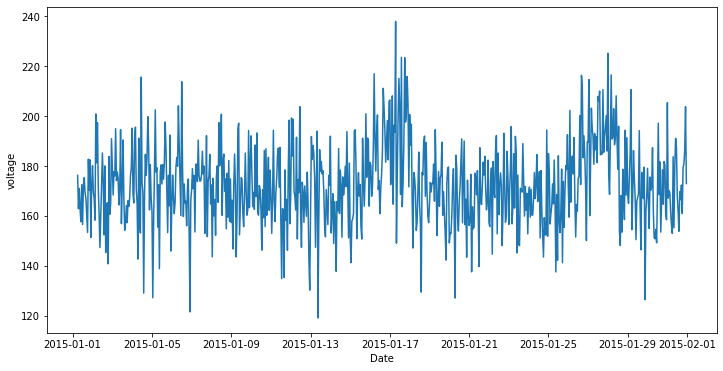

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), 
                        ['datetime', 'volt']]

plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')
plt.xlabel('Date')

### 錯誤日誌 (errors)
第二個主要數據源是錯誤日誌。這些是在機器仍在運行時拋出的非中斷錯誤，並不構成故障 (failure)

In [4]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print('總數據量: {}'.format(len(errors)))
errors.head()

總數據量: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


Text(0, 0.5, 'Count')

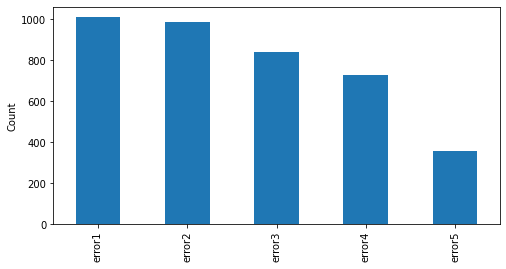

In [5]:
plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')

### 維護 (maint)

這些是定期和非定期的維護記錄，它們與零件定期檢查和故障記錄相對應。如果某個零件在計劃檢查期間被替換或由於故障而被替換，則會生成一個記錄。由於故障而創建的記錄將稱為故障。

In [6]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print('總數據量: {}'.format(len(maint)))
maint.head()

總數據量: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


Text(0, 0.5, 'Count')

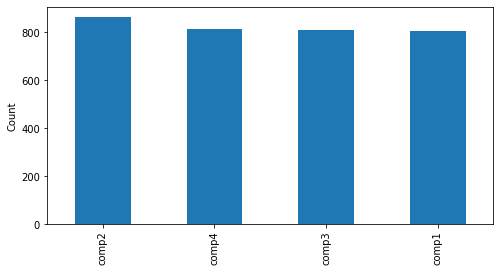

In [7]:
plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')

### 機器 (machines)
此數據集包括有關機器的一些信息:模型類型和使用年限

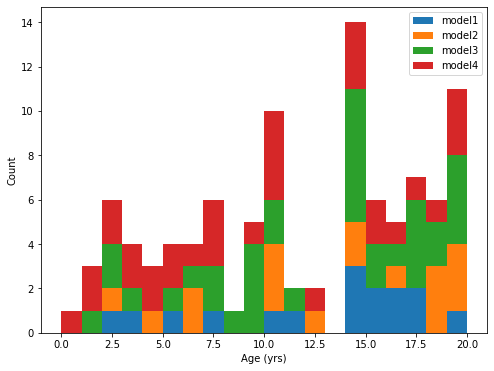

In [8]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

### 故障 (failures)

這些是由於故障而更換零件的記錄。每個記錄都有日期和時間、機器ID和失敗的零件類型。

In [9]:
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('總數據量: {}'.format(len(failures)))
failures.head()

總數據量: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

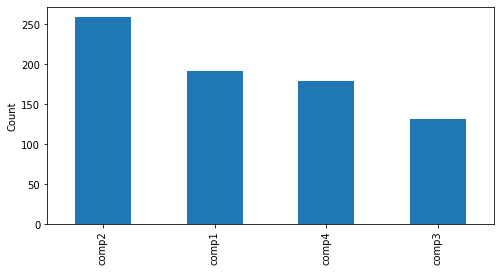

In [10]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## 特徵工程

預測性維護應用程序的第一步是特徵工程，它需要整合不同的數據源，以建立能夠在最佳描述機器健康狀況的特徵。

### 取出 telemetry 特徵

In [11]:
# 計算每三小時平均值
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

telemetry_mean_3h.head(3)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405


In [12]:
# 計算每三小時標準差
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_sd_3h.head(3)

,machineID,datetime,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304


In [13]:
# 計算每24小時平均值
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]
telemetry_mean_24h.head(3)

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374


In [14]:
# 計算每24小標準差
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).std().resample('3H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.head()

,machineID,datetime,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069


In [15]:
# 合併數據欄位
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head(3)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076


### 取出 errors 特徵

In [16]:
errors.head(3)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5


In [17]:
error_count = pd.get_dummies(errors)
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head(3)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1


### 將錯誤數量與 telemetry 合併，已取得沒有錯誤時的時間資訊

In [18]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.head(3)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0


### 計算24 小時內的錯誤數量 (每三小時為單位)

In [19]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).sum().resample('3H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.head(3)

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0


### 從上次替換零件至今的天數

本例中的一個關鍵數據集是維護記錄，其中包含零件更換記錄的信息。該數據集的可能特徵可以是：

在過去3個月內替換每個組件的次數，以包含替換頻率。然而，更相關的信息將為最後一次替換組件以來過了多久，因為零件使用的時間越長，需要維修的可能性越高

In [20]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [21]:
import numpy as np

# 建立錯誤型態欄位
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# 找出該機器於單一時間點的維修次數
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# 補上沒有維修時的時間
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
876100,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
876101,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
876102,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
876103,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [22]:
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # 找出最近更換零件時間
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # 補上最近更換零件時間
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    
# 移除包含遺失值的訊息    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# 建立更換零件時間差特徵
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'].astype(np.int64) - comp_rep[comp]).apply(lambda x: x /86400E9)
    
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


### 合併telemetry, comp_rep, error_count, machines 等所有數據特徵

In [26]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat.head(3)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18


## 建立 X (特徵: final_feat) 與 y (故障：failures)

In [27]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.bfill(axis = 1, limit=7) 
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


## 建立訓練與測試數據集

In [28]:
last_train_date, first_test_date = pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')

train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))

## 建立模型

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(train_X, train_y)
    

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## 將模型套用至測試數據集

In [30]:
test_y = labeled_features.loc[labeled_features['datetime'] > first_test_date, 'failure']
pred_y = clf.predict(test_X)

## 檢視特徵重要性

Text(0, 0.5, 'Importance')

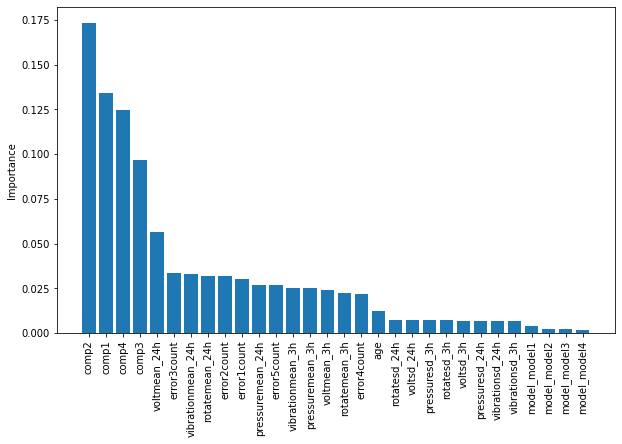

In [32]:
import operator

plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, clf.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

## 評估模型

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(accuracy_score(test_y, pred_y))

0.999845048483514


In [34]:
labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4']
cm = confusion_matrix(test_y, pred_y, labels = labels)
print(labels)
print(cm)

['none', 'comp1', 'comp2', 'comp3', 'comp4']
[[122316      0      0      0      0]
 [     0     61      2      0      3]
 [     0      1    111      0      0]
 [     0      3      2     46      1]
 [     0      0      7      0     66]]


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

       comp1       0.94      0.92      0.93        66
       comp2       0.91      0.99      0.95       112
       comp3       1.00      0.88      0.94        52
       comp4       0.94      0.90      0.92        73
        none       1.00      1.00      1.00    122316

    accuracy                           1.00    122619
   macro avg       0.96      0.94      0.95    122619
weighted avg       1.00      1.00      1.00    122619

